# Data Science Project - Group 5 (Goldman Grinders)

Data analysis with data from the Federal Reserve Bank of st. Louis.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2 # install with pip install matplotlib-venn
import pandas_datareader # install with `pip install pandas-datareader`
import pydst # install with `pip install git+https://github.com/elben10/pydst`
import datetime
import math
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import dataproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importing tables from the FRED source, we have chosen $1$-Year Treasury Constant Maturity Rate (DGS1), $10$-Year Treasury Constant Maturity Rate (DGS10) and Wilshire 5000 Full Cap Price Index (Will5000prfc) where all the timeseries end in $25^{th}$ of March 2020. Note the different starttime, this will be corrected for in the code later.

In [14]:
# a. load

#Setting times:
start = datetime.datetime(1950,1,1)
end = datetime.datetime(2020,3,27)


#Loading data for stock index, two interest rates for rate spread:
stocks = pandas_datareader.data.DataReader('WILL5000PRFC','fred',start,end)
dgs1 = pandas_datareader.data.DataReader('dgs1','fred',start,end)
dgs10 = pandas_datareader.data.DataReader('dgs10','fred',start,end)

#Renaming stocks-column for easier retreival:
stocks.rename(columns={'WILL5000PRFC':'stocks'},inplace=True)

#Merging data into single dataframe:
mellemregning = pd.merge(stocks,dgs1,how='inner',left_index=True,right_index=True)
data = pd.merge(mellemregning,dgs10,how='inner',left_index=True,right_index=True)

#Deleting NaN:
data.dropna(inplace=True)

#Defining spread:
data['spread'] = data['dgs10']-data['dgs1']
data['logstocks'] = [
    math.log(i)
    for i in data['stocks']
]

#Creating moving averages:
data['stocks_mvavg'] = data['logstocks'].rolling(window=1000).mean(center=True)
data['dgs10_mvavg'] = data['dgs10'].rolling(window=1000).mean(center=True)


data

,stocks,dgs1,dgs10,spread,logstocks,stocks_mvavg,dgs10_mvavg
DATE,,,,,,,
1970-12-31,830.27,4.94,6.50,1.56,6.721751,NaN,NaN
1971-01-29,873.31,4.23,6.09,1.86,6.772291,NaN,NaN
1971-02-26,885.37,3.69,6.14,2.45,6.786006,NaN,NaN
1971-03-31,923.13,3.92,5.53,1.61,6.827770,NaN,NaN
1971-04-30,955.25,4.77,6.08,1.31,6.861973,NaN,NaN
...,...,...,...,...,...,...,...
2020-03-20,23082.46,0.15,0.92,0.77,10.046828,NaN,NaN
2020-03-23,22463.62,0.17,0.76,0.59,10.019652,NaN,NaN
2020-03-24,24542.52,0.25,0.84,0.59,10.108162,NaN,NaN


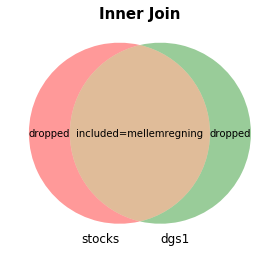

In [15]:
#Plotting a venn-digram of the merging method for "mellemregning"
plt.figure()
v = venn2(subsets = (4, 4, 10), set_labels = ('stocks', 'dgs1'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped')
v.get_label_by_id('110').set_text('included=mellemregning')
plt.title('Inner Join', weight='bold',fontsize=15)
plt.show()

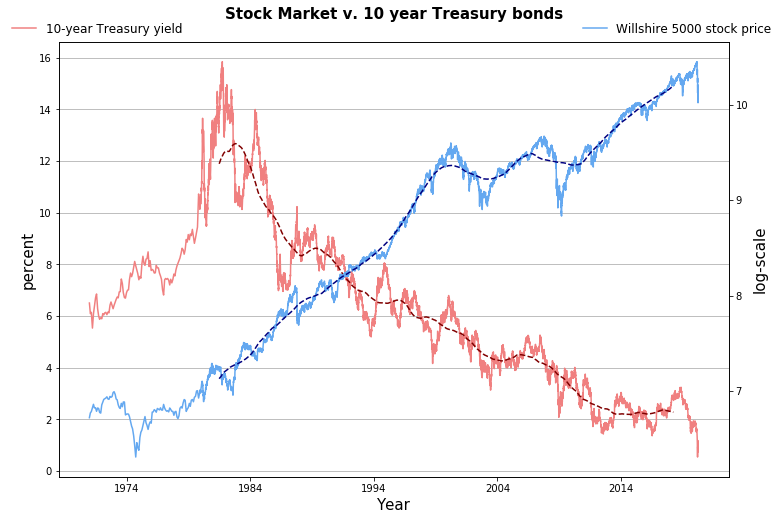

In [16]:
#Plotting:
fig, ax1 = plt.subplots(figsize=(12,8))
plt.title('Stock Market v. 10 year Treasury bonds',fontsize=15,weight='bold',pad=23)
plt.xlabel('Year',fontsize=15)

ax1.plot(data['dgs10'], label='10-year Treasury yield',c='lightcoral')
ax1.plot(data['dgs10_mvavg'],c='maroon',linestyle='--',label='__no_legend__')
ax1.grid(axis='y')
plt.ylabel('percent',fontsize=15)
plt.legend(frameon=False,bbox_to_anchor=(0.2,1.07),fontsize=12)

ax2 = ax1.twinx()
goldman_blue = '#64a8f0'
ax2.plot(data['logstocks'], label='Willshire 5000 stock price',c=goldman_blue)
ax2.plot(data['stocks_mvavg'],c='navy',linestyle='--',label='__no_legend__')
plt.ylabel('log-scale',fontsize=15)
plt.legend(frameon=False,bbox_to_anchor=(1.08,1.07),fontsize=12)
plt.savefig('Stocks vs Bonds.pdf')


# Regression analysis

In [17]:
#Defining regression model::
import statsmodels.api as sm

X = sm.add_constant(data['dgs10'])
model = sm.OLS(data['logstocks'],X)
results = model.fit()
results.params
print(results.summary())
print(np.std(data['logstocks']))

OLS Regression Results                            
Dep. Variable:              logstocks   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                 5.610e+04
Date:                Sun, 29 Mar 2020   Prob (F-statistic):               0.00
Time:                        21:15:39   Log-Likelihood:                -4470.2
No. Observations:               10176   AIC:                             8944.
Df Residuals:                   10174   BIC:                             8959.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4443      0.008   1350.179      0.000      10.429      10.460
d

In the following code we perform a regression with OLS. Note that we have chosen the $10$-year maturity rate, since this will represent the most realistic trading trade-off. Our model is: 
$$log(stocks_i)=\beta_0+\beta_1dgs10_i$$

Where $stocks_i$ is the Willshire5000 stock index closing price for a given day i, and $dgs10_i$ denotes the yield of 10-year Treasury Bonds for day i.

Thus, we interpret the $\beta_1$-parameter as the percentage change in stock prices resulted from an increase in the Treasury yield by 1 percentage point

We conclude that the dgs10 parameter affects the $10$-year maturity rate significantly negative, thus when the maturity rate increases with $1 \%$-point the stocks are estimated to decrease with $26\%$

# Forecasting

We want to extrapolate the stock-data by the model:
$$ y_{t+1} = y_{t} + \tilde{s}, \hspace{10mm} s \sim N(\delta_1,\sigma^2)$$

Where $y_t$ is the stock-price in period $t$, $\delta_1$ is the slope parameter of the stock price regressed on time, and $\tilde{s} \sim N(\delta_1,\sigma^2)$ is a period-wise chock having the expected value of $\delta_1$, and variance of the daily price change.

Note, that:
$$ \tilde{s} = 0 \hspace{5mm} for \hspace{5mm} t \in [0;sup(t)]$$
$$ \tilde{s} \sim N(\delta_1,\sigma^2) \hspace{5mm} for \hspace{5mm} t \in ]sup(t);\infty[ $$

That is, the chock is not included in our data until we extrapolate the time series.

First, we seek to estimate $\delta_1$ by OLS. Second, we estimate $\sigma^2$ as the variance in the daily change in the stock price Third, we estimate the model mentioned above. At last, we graph our findings.

In [18]:
#Appending time-series to data:
data['t'] = range(0,len(data['logstocks']))

#Then, regressing (stock price without log):
X = sm.add_constant(data['t'])
model = sm.OLS(data['stocks'],X)
results = model.fit()
results.params
print(results.summary())

#We find delta to be 2,49
delta_0 = -2584.1726
delta_1 = 2.4942

OLS Regression Results                            
Dep. Variable:                 stocks   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 6.181e+04
Date:                Sun, 29 Mar 2020   Prob (F-statistic):               0.00
Time:                        21:15:45   Log-Likelihood:                -95818.
No. Observations:               10176   AIC:                         1.916e+05
Df Residuals:                   10174   BIC:                         1.917e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2584.1726     58.936    -43.847      0.000   -2699.699   -2468.646
t

In [19]:
#We start out by finding an estimate of the variance in daily price change, to be used for the daily chock.
data['dailychange'] = [
    data['stocks'][i]-data['stocks'][i-1]
    for i in range(0,len(data['stocks']))
]
data['dailychange'][0] = 0
data
data['dailychange'].describe()

sigma = 143.97
# We find and define the standard deviation for use in the forecast.

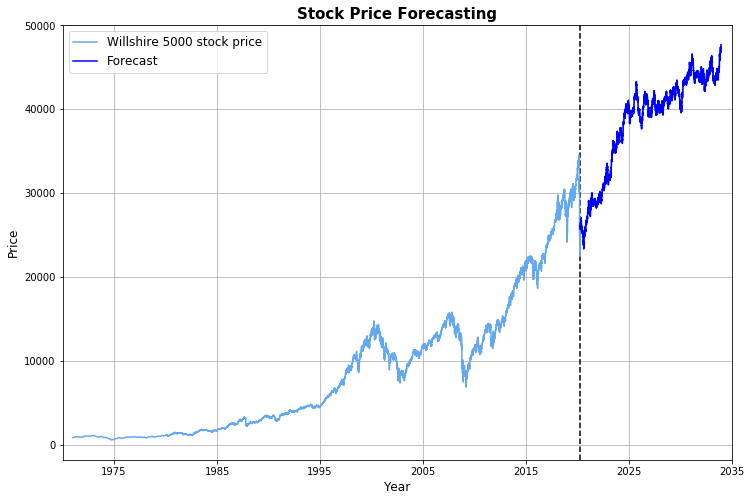

In [21]:
#FORECAST:

#We start extrapolating, by starting at the last known stock-price, thereafter adding the chock-value to this, having an expected value of the estimated change in stock-price per period (day):
extra = []
extra.append(data['stocks'][-1])
for i in range(1,5000):
    s = np.random.normal(loc=delta_1, scale=sigma, size=None,)
    extra.append(
            extra[i-1] + s
            )

pd_extra = pd.DataFrame(extra)

#Concatenating the known values with the extrapolated ones:
forecast = pd.DataFrame(pd.concat([data['stocks'],pd_extra],ignore_index=True))
forecast.rename(columns={0:'stocks'},inplace=True)

#Concatenating the x-values, dates, by appending 5000 new dates (each consisting of 1440 min) to the known dates:
dates_0 = pd.DatetimeIndex(data.index.values)
dates_1 = pd.date_range('2020-03-26', periods=5000, freq='1440min')
dates = dates_0.append(dates_1)

forecast['log_stocks'] = [
    math.log(i)
    for i in forecast['stocks']
]

#FIGURE:

fig, ax1 = plt.subplots(figsize=(12,8))
ax1.xaxis.grid(True, which='major')
ax1.xaxis.grid(True, which='minor')
ax1.yaxis.grid(True)
plt.title('Stock Price Forecasting', fontsize=15,weight='bold')
ax1.axvline(pd.datetime(2020,3,26),linestyle='--',c='black')

ax1.plot(dates,forecast['stocks'],c=goldman_blue, label='Willshire 5000 stock price')
distance=len(forecast)-len(data)
ax1.plot(
    dates[len(data):len(forecast)],forecast['stocks'][len(data):len(forecast)],
    color='blue',
    label='Forecast'
)
ax1.set_xlim('1970-1-1','2035-1-1')
plt.legend(fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price', fontsize=12)

plt.savefig('Forecast.pdf')
